# Di-Higgs regressor final training

## Import

### Import modules

In [82]:
import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise, BatchNormalization, Merge
from keras.layers.advanced_activations import ELU, PReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras import backend as K
from __future__ import division ,print_function
import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
from sklearn.pipeline import Pipeline
import json
import glob
import pickle
from sklearn.externals import joblib
import seaborn as sns
import sys
sys.path.append('../../../../modules')
from MPPlot import *
from Processors import *
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
sys.path.append('../')
from Regression_Application import *


### Import data
Here just looking at mu tau_h b b final-state

In [83]:
mode = "mu_tau_b_b"
loc = '../../../../../data_n/'
SignalData = []
BackgroundData = []

energies = ['400']
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((energies,backgrounds))

def backgroundName(background):
    if background == 'TT':
        return loc + 'TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv'
    elif background == 'WJetsToLNu':
        return loc + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv'



 #Load data from CSV files
for energy in energies:
    signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(energy) +"_narrow_13TeV-madgraph.csv")
    signaldata['gen_label'] = energy
    SignalData.append(signaldata)


for back in backgrounds:
    backgroundData = pandas.read_csv(backgroundName(back))
    backgroundData['gen_label'] = back
    BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)    
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)    
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))
backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))

print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset


def abs_(x):
    if type(x) is float:
        return abs(x)
    else:
        return x

def cleanData(X):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    X.applymap(abs_)
    
    
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X

data = cleanData(data)

Samples contains 655 signal events and 168053 background events
168708 events in total


## Configure data

### Create development and validation samples

In [84]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH', 'gen_t_0', 'gen_t_1', 'gen_b_0' ,'gen_b_1']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    if(not str.startswith(p, "gen")):
        addEnergy(data, p) #Calculate energy and absolute momentum
 

moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu
addHighLvl(data)
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

In [85]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)

    
devData = data.loc[sig_devIndeces].copy()
#devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))


223 events for training, 168477 events for validation


### Apply regressors

In [86]:
btrain = ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t_1_b_0', 'hl_dpz_t_1_b_0', 'hl_dpx_t_1_b_1', 'hl_dpy_t_1_b_1', 'hl_dpz_t_1_b_1', 'hl_dpx_t_1_t_0', 'hl_dpy_t_1_t_0', 'hl_dpz_t_1_t_0', 'hl_dpx_t_1_mPT', 'hl_dpy_t_1_mPT', 'hl_dpx_diH_h_bb', 'hl_dpy_diH_h_bb', 'hl_dpz_diH_h_bb', 'hl_dpx_diH_h_tt', 'hl_dpy_diH_h_tt', 'hl_dpz_diH_h_tt', 'hl_dpx_diH_mPT', 'hl_dpy_diH_mPT', 'hl_dpx_h_bb_diH', 'hl_dpy_h_bb_diH', 'hl_dpz_h_bb_diH', 'hl_dpx_h_bb_h_tt', 'hl_dpy_h_bb_h_tt', 'hl_dpz_h_bb_h_tt', 'hl_dpx_h_bb_mPT', 'hl_dpy_h_bb_mPT', 'hl_dpx_h_tt_diH', 'hl_dpy_h_tt_diH', 'hl_dpz_h_tt_diH', 'hl_dpx_h_tt_h_bb', 'hl_dpy_h_tt_h_bb', 'hl_dpz_h_tt_h_bb', 'hl_dpx_h_tt_mPT', 'hl_dpy_h_tt_mPT', 'hl_mT', 'h_tt_mass', 'h_tt_svFit_mass', 'h_bb_mass', 'diH_mass', 'diH_kinFit_mass', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'hl_mT']
bRegressor = BPairRegressor(data, "../bRegression/weights/NN_B_Regressor_App_" + mode + "_"  , mode , btrain)
bRegressor.evalResponse()
bRegressor.getExtraVariables()
bRegressor.refineDiHiggsVector()

(10, 'components found in ensemble')


In [87]:
ttrain = ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t_1_b_0', 'hl_dpz_t_1_b_0', 'hl_dpx_t_1_b_1', 'hl_dpy_t_1_b_1', 'hl_dpz_t_1_b_1', 'hl_dpx_t_1_t_0', 'hl_dpy_t_1_t_0', 'hl_dpz_t_1_t_0', 'hl_dpx_t_1_mPT', 'hl_dpy_t_1_mPT', 'hl_dpx_diH_h_bb', 'hl_dpy_diH_h_bb', 'hl_dpz_diH_h_bb', 'hl_dpx_diH_h_tt', 'hl_dpy_diH_h_tt', 'hl_dpz_diH_h_tt', 'hl_dpx_diH_mPT', 'hl_dpy_diH_mPT', 'hl_dpx_h_bb_diH', 'hl_dpy_h_bb_diH', 'hl_dpz_h_bb_diH', 'hl_dpx_h_bb_h_tt', 'hl_dpy_h_bb_h_tt', 'hl_dpz_h_bb_h_tt', 'hl_dpx_h_bb_mPT', 'hl_dpy_h_bb_mPT', 'hl_dpx_h_tt_diH', 'hl_dpy_h_tt_diH', 'hl_dpz_h_tt_diH', 'hl_dpx_h_tt_h_bb', 'hl_dpy_h_tt_h_bb', 'hl_dpz_h_tt_h_bb', 'hl_dpx_h_tt_mPT', 'hl_dpy_h_tt_mPT', 'hl_mT', 'regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_0_|p|', 'regB_b_0_E', 'regB_b_1_|p|', 'regB_b_1_E', 'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regB_h_bb_E', 'regB_h_bb_|p|', 'regB_h_bb_mass', 'regB_diH_px', 'regB_diH_py', 'regB_diH_pz', 'regB_diH_E', 'regB_diH_|p|', 'regB_diH_mass', 'h_tt_mass', 'h_tt_svFit_mass', 'diH_kinFit_mass', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'hl_mT']
tauRegressor = TauPairRegressor(data, "../tauRegression/weights/NN_Tau_Regressor_App_" + mode + "_"  , mode, ttrain )
tauRegressor.evalResponse()
tauRegressor.getExtraVariables()
tauRegressor.refineDiHiggsVector()

(10, 'components found in ensemble')


In [88]:
hhtrain = ['t_0_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t_1_b_0', 'hl_dpz_t_1_b_0', 'hl_dpx_t_1_b_1', 'hl_dpy_t_1_b_1', 'hl_dpz_t_1_b_1', 'hl_dpx_t_1_t_0', 'hl_dpy_t_1_t_0', 'hl_dpz_t_1_t_0', 'hl_dpx_t_1_mPT', 'hl_dpy_t_1_mPT', 'hl_dpx_diH_h_bb', 'hl_dpy_diH_h_bb', 'hl_dpz_diH_h_bb', 'hl_dpx_diH_h_tt', 'hl_dpy_diH_h_tt', 'hl_dpz_diH_h_tt', 'hl_dpx_diH_mPT', 'hl_dpy_diH_mPT', 'hl_dpx_h_bb_diH', 'hl_dpy_h_bb_diH', 'hl_dpz_h_bb_diH', 'hl_dpx_h_bb_h_tt', 'hl_dpy_h_bb_h_tt', 'hl_dpz_h_bb_h_tt', 'hl_dpx_h_bb_mPT', 'hl_dpy_h_bb_mPT', 'hl_dpx_h_tt_diH', 'hl_dpy_h_tt_diH', 'hl_dpz_h_tt_diH', 'hl_dpx_h_tt_h_bb', 'hl_dpy_h_tt_h_bb', 'hl_dpz_h_tt_h_bb', 'hl_dpx_h_tt_mPT', 'hl_dpy_h_tt_mPT', 'hl_mT', 'regB_b_0_px', 'regB_b_0_py', 'regB_b_0_pz', 'regB_b_1_px', 'regB_b_1_py', 'regB_b_1_pz', 'regB_b_0_|p|', 'regB_b_0_E', 'regB_b_1_|p|', 'regB_b_1_E', 'regB_h_bb_px', 'regB_h_bb_py', 'regB_h_bb_pz', 'regB_h_bb_E', 'regB_h_bb_|p|', 'regB_h_bb_mass', 'regTau_t_0_px', 'regTau_t_0_py', 'regTau_t_0_pz', 'regTau_t_1_px', 'regTau_t_1_py', 'regTau_t_1_pz', 'regTau_t_0_|p|', 'regTau_t_0_E', 'regTau_t_1_|p|', 'regTau_t_1_E', 'regTau_h_tt_px', 'regTau_h_tt_py', 'regTau_h_tt_pz', 'regTau_h_tt_E', 'regTau_h_tt_|p|', 'regTau_h_tt_mass', 'regTau_diH_px', 'regTau_diH_py', 'regTau_diH_pz', 'regTau_diH_E', 'regTau_diH_|p|', 'regTau_diH_mass', 'h_tt_svFit_mass', 'diH_kinFit_mass', 'hl_mT']
hhMomRegressor = HHMomRegressor(data, "../hhMomRegression/weights/NN_HH_Mom_Regressor_App_" + mode + "_" , mode, hhtrain)
hhMomRegressor.evalResponse()
hhMomRegressor.getExtraVariables()

(10, 'components found in ensemble')


## Save/load

In [89]:
data.rename(columns={'weight': 'gen_weight'}, inplace=True)
genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi'] if x in var]
other = [var for var in trainFeatures for x in [ 'prob'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi + other]

In [90]:
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT','mT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
regFeatures = [var for var in trainFeatures if (str.startswith(var, "reg"))]
regBFeatures = [var for var in trainFeatures if (str.startswith(var, "regB_"))]
regTauFeatures = [var for var in trainFeatures if (str.startswith(var, "regTau_"))]
regHHMomFeatures = [var for var in trainFeatures if (str.startswith(var, "regHH_"))]
regBDiHiggs = [var for var in regBFeatures if (str.startswith(var, "regB_diH_"))]
regTauDiHiggs = [var for var in regTauFeatures if (str.startswith(var, "regTau_diH_"))]
diHiggsFeatures = [var for var in trainFeatures if (str.startswith(var, "diH_"))]
regBasis = [var[var.find("_")+1:] for var in regFeatures]
massFeatures = [var for var in trainFeatures if "_mass" in var]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in  shapeFeatures + pTEtaPhi  + recoFeatures]
reducedFSFeatures = [var for var in fsFeatures if var not in regBasis]
reducedRecoFeatures = [var for var in recoFeatures if var not in regBasis]


In [91]:
set0 = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi + regBFeatures + regTauFeatures + regHHMomFeatures] + ['hl_mT']
set1 = [var for var in reducedFSFeatures + reducedRecoFeatures if var not in pTEtaPhi + regBDiHiggs + regHHMomFeatures] + ['hl_mT']
set2 = [var for var in reducedFSFeatures + reducedRecoFeatures if var not in pTEtaPhi + regBDiHiggs + regTauDiHiggs + shapeFeatures] + ['hl_mT'] + ['regTau_diH_mass']

## Specify options

In [92]:
regTrainFeatures = set2
regModel = 'model0'
normIn = True
normOut = True
pca = True
whiten = False
nSplits = 10
cvTests = True
ensembleSize = 10
ensembleMode = 'loss'
regTargetFeatures = ['gen_diH_mass']
print("\nTraining on", len(regTrainFeatures), "features:", [var for var in regTrainFeatures])
print("\nRegressing to", len(regTargetFeatures), "features:", [var for var in regTargetFeatures])


Training on 125 features: ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t_1_b_0', 'hl_dpz_t_1_b_0', 'hl_dpx_t_1_b_1', 'hl_dpy_t_1_b_1', 'hl_dpz_t_1_b_1', 'hl_dpx_t_1_t_0', 'hl_dpy_t_1_t_0', 'hl_dpz_t_1_t_0', 'hl_dpx_t_1_mPT', 'hl_dpy_t_1_mPT', 'hl_dpx_diH_h_bb', 'hl_dpy_di

In [93]:
devData = data.loc[sig_devIndeces].copy()
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)
print ("{0} events for training, {1} events for validation".format(len(devData), len(valData)))

223 events for training, 168477 events for validation


In [94]:
name = "weights/NN_HH_Regressor_App_" + mode + "_" 
print (name)

weights/NN_HH_Regressor_App_mu_tau_b_b_


### Load

In [95]:
ensemble = []
weights = None
inputPipe = None
outputPipe = None
compileArgs = None
with open(name + '_compile.json', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    ensemble.append(model)
with open(name + '_weights.pkl', 'r') as fin:
    weights = pickle.load(fin)
with open(name + '_inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)
with open(name + '_outputPipe.pkl', 'r') as fin:
    outputPipe = pickle.load(fin)

## Define regressor

## Evaluation

### Calculate pull

In [96]:
def getResponse(pred, act):
    pull = pred[:,0]-act
    return (pull.mean(), pull.std())

### Preprocess data

In [97]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
inputPipe = Pipeline(stepsIn)
stepsOut = []
if normOut:
    stepsOut.append(('normOut', StandardScaler()))
else:
    stepsOut.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
outputPipe = Pipeline(stepsOut)

In [98]:
X_reg = inputPipe.fit_transform(devData[regTrainFeatures].values.astype(theano.config.floatX))
y_reg = outputPipe.fit_transform(devData[regTargetFeatures].values.astype(theano.config.floatX))

## Construct ensemble

In [99]:
results = None
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [100]:
def loadModel(cycle, location='train_weights/train_'):
    cycle = int(cycle)
    model = load_model(location + str(cycle) + '.h5')
    model.compile(**compileArgs)
    return model

In [101]:
def getWeights(value, met):
    return 1/value

In [102]:
ensemble = []
weights = []
print ("Choosing ensemble by", ensembleMode)
if ensembleMode == 'mix':
    for met in results[0]:
        print( "Choosing best for metric", met)
        cycle = np.argmin([result[met] for result in results])
        print (met, "Model", "is", cycle, "with", met, "=", results[cycle][met])
        ensemble.append(loadModel(cycle))
        weights.append(1)
else:
    dtype = [('cycle', int), ('result', float)]
    values = np.sort(np.array([(i, result[ensembleMode]) for i, result in enumerate(results)], dtype=dtype),
                     order=['result'])
    for i in range(min([ensembleSize, len(results)])):
        ensemble.append(loadModel(values[i]['cycle']))
        weights.append(getWeights(values[i]['result'], ensembleMode))
        print ("Model", i, "is", values[i]['cycle'], "with", ensembleMode, "=", values[i]['result'])
weights = np.array(weights)
weights = weights/weights.sum() #normalise weights

Choosing ensemble by loss
Model 0 is 5 with loss = 0.0412733954755
Model 1 is 3 with loss = 0.0449227407108
Model 2 is 8 with loss = 0.0496394694254
Model 3 is 2 with loss = 0.0501692724136
Model 4 is 1 with loss = 0.0501876177713
Model 5 is 9 with loss = 0.0510492746492
Model 6 is 6 with loss = 0.0516127296598
Model 7 is 4 with loss = 0.0534179467718
Model 8 is 0 with loss = 0.0547251790923
Model 9 is 7 with loss = 0.0581996900004


## Response of ensemble on development data

###  Preprocess data

In [103]:
X_dev = inputPipe.transform(devData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [104]:
pred = np.zeros((len(devData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_dev, verbose=0)) 
devData['regHH_diH_mass'] = pandas.Series(pred[:,0], index=devData.index)

### Evaluate response

In [105]:
devData['loss_d'] = 0
for n, feature in enumerate(regTargetFeatures):
    devData.loc[:, 'loss_d'] += np.square(devData.loc[:, 'regHH_' + feature[4:]]-devData.loc[:, feature])
meanBootReg = []
stdevBootReg = []
for i in range(100):
    points = np.random.choice(devData['regHH_diH_mass'].values-devData['gen_diH_mass'].values, len(devData), replace=True)
    meanBootReg.append(points.mean())
    stdevBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
print ('Ensemble on dev data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(devData.loc[:, 'loss_d'])/len(regTargetFeatures), meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))

Ensemble on dev data:
 Loss = 7.50044253979e-06, Mean = -5.48065025836e-05 +- 1.83772946685e-05, sigma = 0.00273637887475 +- 2.67512867508e-05


## Response of ensemble on validation data

###  Preprocess data

In [106]:
X_val = inputPipe.transform(valData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [107]:
pred = np.zeros((len(valData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_val, verbose=0)) 
valData['regHH_diH_mass'] = pandas.Series(pred[:,0], index=valData.index)

### Evaluate response

In [108]:
valData['loss_v'] = 0
for n, feature in enumerate(regTargetFeatures):
    valData.loc[sig, 'loss_v'] += np.square(valData.loc[sig, 'regHH_' + feature[4:]]-valData.loc[sig, feature])
meanBootReg = []
stvalBootReg = []
for i in range(100):
    points = np.random.choice(valData[sig]['regHH_diH_mass'].values-valData[sig]['gen_diH_mass'].values, len(valData[sig]), replace=True)
    meanBootReg.append(points.mean())
    stvalBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stvalReg = (np.mean(stvalBootReg), np.std(stvalBootReg)/math.sqrt(len(stvalBootReg)))
print ('Ensemble on val data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(valData.ix[sig, 'loss_v'])/len(regTargetFeatures), meanReg[0], meanReg[1], stvalReg[0], stvalReg[1]))

Ensemble on val data:
 Loss = 9.75622063988e-06, Mean = 0.000134270811963 +- 4.78860193416e-05, sigma = 0.00295356896514 +- 8.30141394392e-05


/home/goncalo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if sys.path[0] == '':
/home/goncalo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  return getattr(section, self.name)[new_key]


### Two-sample Kolmogorov–Smirnov test

In [109]:
for n, feature in enumerate(regTargetFeatures):
    print ()
    print (feature)
    ksTest = ks_2samp(valData[sig][feature].values, valData[sig]['regHH_' + feature[4:]].values)
    print ("K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1]))


gen_diH_mass
K-S test result 0.1786, p-value of 0.3035


### Di-Higgs mass distribution

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


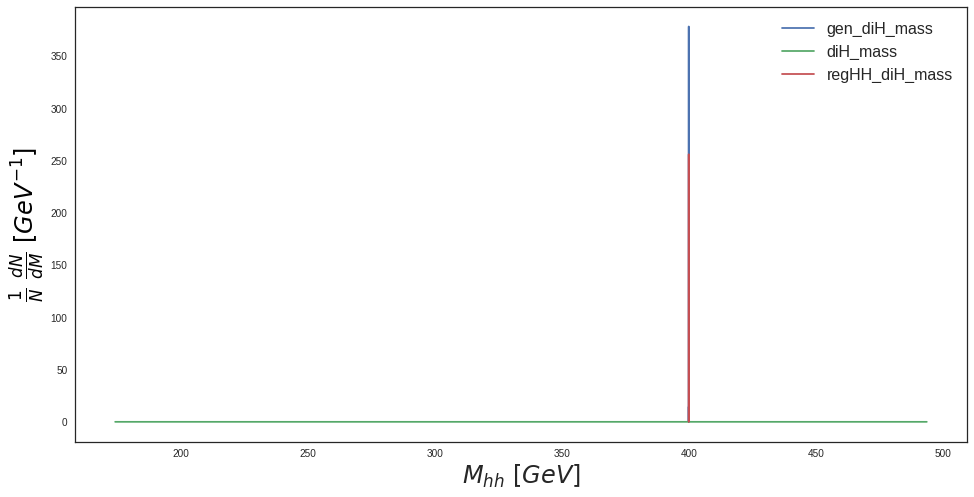

In [ ]:
plt.figure(figsize=(16, 8))

sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'])

sns.kdeplot(data=valData.loc[sig, 'diH_mass'])

sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'])
plt.legend(fontsize=16)
plt.xlabel(r"$M_{hh}\ [GeV]$", fontsize=24)
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dM}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [ ]:
xPlot = np.linspace(0, 1500, 1500)[:, np.newaxis]
plots = mpRun([{'data':valData.loc[bkg, 'diH_mass'], 'x':xPlot, 'name':'bkg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[bkg, 'regHH_diH_mass'], 'x':xPlot, 'name':'bkg_reg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'diH_mass'], 'x':xPlot, 'name':'sig', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'regHH_diH_mass'], 'x':xPlot, 'name':'sig_reg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'gen_diH_mass'], 'x':xPlot, 'name':'gen', 'kde':1, 'mean':1, 'std':1}])

In [ ]:
meanReco = (np.mean(plots['sig' + '_mean']),
            np.std(plots['sig' + '_mean'])/math.sqrt(len(plots['sig' + '_mean'])))
stdReco = (np.mean(plots['sig' + '_std']),
             np.std(plots['sig' + '_std'])/math.sqrt(len(plots['sig' + '_std'])))
meanReg = (np.mean(plots['sig_reg' + '_mean']),
            np.std(plots['sig_reg' + '_mean'])/math.sqrt(len(plots['sig_reg' + '_mean'])))
stdReg = (np.mean(plots['sig_reg' + '_std']),
             np.std(plots['sig_reg' + '_std'])/math.sqrt(len(plots['sig_reg' + '_std'])))
meanGen = (np.mean(plots['gen' + '_mean']),
            np.std(plots['gen' + '_mean'])/math.sqrt(len(plots['gen' + '_mean'])))
stdGen = (np.mean(plots['gen' + '_std']),
             np.std(plots['gen' + '_std'])/math.sqrt(len(plots['gen' + '_std'])))

In [ ]:
plt.figure(figsize=(16, 8))
#sns.kdeplot(data=valData.loc[bkg, 'diH_mass'])
sns.kdeplot(data=valData.loc[bkg, 'regHH_diH_mass'])
#sns.kdeplot(data=valData.loc[sig, 'diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'regHH_diH_mass'])
sns.kdeplot(data=valData.loc[sig, 'gen_diH_mass'])
plt.xlabel(r"$M_{hh}\ [GeV]$", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dM}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.xlim(10,800)
plt.show()


In [ ]:
pullRegHH = valData[sig]['regHH_diH_mass'].values-valData[sig]['gen_diH_mass'].values
pullReco = valData[sig]['diH_mass'].values-valData[sig]['gen_diH_mass'].values
xPlot = np.linspace(-300, 300, 600)[:, np.newaxis]
bootReco = []
meanBootReco = []
stdevBootReco = []
for i in range(100):
    points = np.random.choice(pullReco, len(pullReco), replace=True)
    meanBootReco.append(points.mean())
    stdevBootReco.append(points.std())
meanReco = (np.mean(meanBootReco), np.std(meanBootReco)/math.sqrt(len(meanBootReco)))
stdevReco = (np.mean(stdevBootReco), np.std(stdevBootReco)/math.sqrt(len(stdevBootReco)))
bootRegHH = []
meanBootRegHH = []
stdevBootRegHH = []
for i in range(100):
    points = np.random.choice(pullRegHH, len(pullRegHH), replace=True)
    meanBootRegHH.append(points.mean())
    stdevBootRegHH.append(points.std())
meanRegHH = (np.mean(meanBootRegHH), np.std(meanBootRegHH)/math.sqrt(len(meanBootRegHH)))
stdevRegHH = (np.mean(stdevBootRegHH), np.std(stdevBootRegHH)/math.sqrt(len(stdevBootRegHH)))
print ('Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRegHH[0], meanRegHH[1], stdevRegHH[0], stdevRegHH[1]))
print ('Reconstructed Signal,  Mean = {} +- {}, sigma = {} +- {}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]))

In [ ]:
xPlot = np.linspace(-300, 300, 600)[:, np.newaxis]
plots = mpRun([{'data':valData.loc[sig, 'diH_mass']-valData.ix[sig,'gen_diH_mass'], 'x':xPlot, 'name':'reco', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'regHH_diH_mass']-valData.ix[sig,'gen_diH_mass'], 'x':xPlot, 'name':'reg', 'kde':1, 'mean':1, 'std':1}])

In [ ]:
meanReco = (np.mean(plots['reco' + '_mean']),
            np.std(plots['reco' + '_mean'])/math.sqrt(len(plots['reco' + '_mean'])))
stdReco = (np.mean(plots['reco' + '_std']),
             np.std(plots['reco' + '_std'])/math.sqrt(len(plots['reco' + '_std'])))
meanReg = (np.mean(plots['reg' + '_mean']),
            np.std(plots['reg' + '_mean'])/math.sqrt(len(plots['reg' + '_mean'])))
stdReg = (np.mean(plots['reg' + '_std']),
             np.std(plots['reg' + '_std'])/math.sqrt(len(plots['reg' + '_std'])))

In [ ]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=pullRegHH)
sns.kdeplot(data=pullReco)
plt.xlabel(r"$M_{hh,\mathrm{Est.}}-M_{hh,\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.yticks
plt.show()

### ROC Curve

In [ ]:
print ('Reg:', roc_auc_score(valData.loc[sig|bkg, 'gen_target'], valData.loc[sig|bkg, 'regHH_diH_mass']))
print ('Reco:', roc_auc_score(valData.loc[sig|bkg, 'gen_target'], valData.loc[sig|bkg, 'diH_mass']))

In [ ]:
sns.distplot(-np.abs(125-valData.loc[sig, 'regHH_diH_mass']), label='signal')
sns.distplot(-np.abs(125-valData.loc[bkg, 'regHH_diH_mass']), label='bkg')
plt.legend()

## Classifiers response

### Train